In [1]:
import numpy as np
from funcs.models import model_ND

##### Below is a generalised model of simple_model.ipynb, allowing for any number of segments.
This model has a few assumptions:
* 1D model, each segment can only transfer heat to neighbouring segments
* There is a heat source which supplies (or draws) heat from segment 0, the magnitude of which is set by Q_in
* The final segment may disspiate heat to surroundings. The outside temperature is set by T_out.

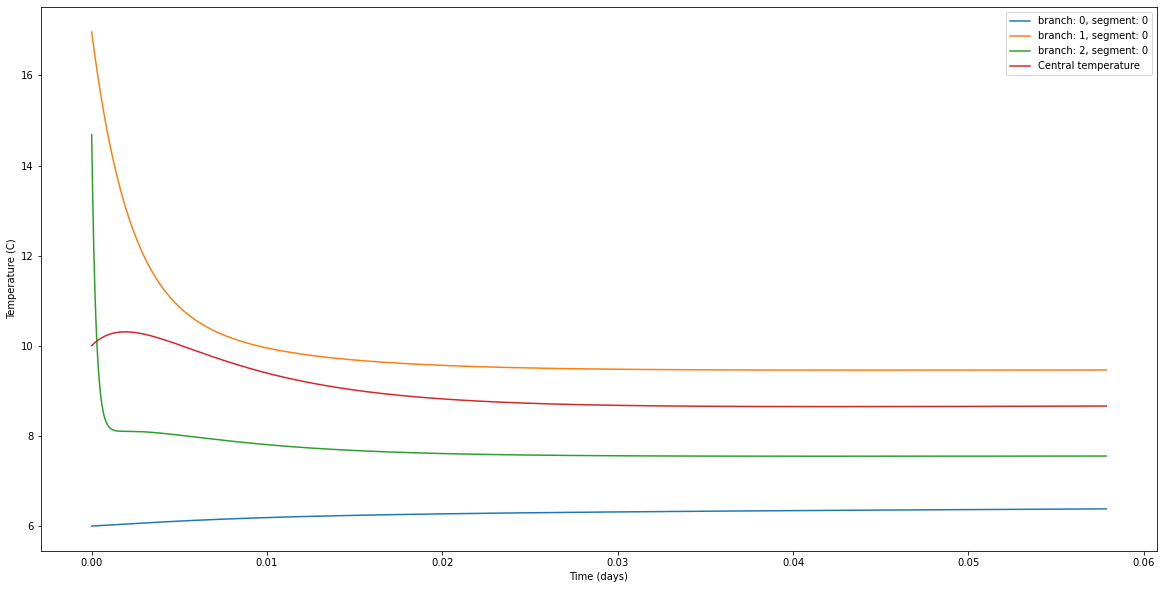

In [14]:
# More complex example, 7 segments in series
# k = [6e5, 2.5e6, 1.1e7]
# c = [800.0, 500.00, 100.0]
# T = [15.0, 20.0, 10.0]
# T_out = [10]
k = [[1e6, 1e7], [2e6, 1e6], [1e8, 1e5]]
c = [[1000.0, 1500.0], [2000.0, 3000.0], [1500.0, 3000.0]]
T = [[10.0, 6.0], [10.0, 17.0], [10.0, 15.0]] # first entry in each sub array must be the same, it is the temperature of the central node
T_out = [5.0, 10.0, 7.0]
heatinput = 1000
# Initialise class with system parameters
sys_nd = model_ND(k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
Ts, Qs = sys_nd.run(iterations=5000, timestep=1)

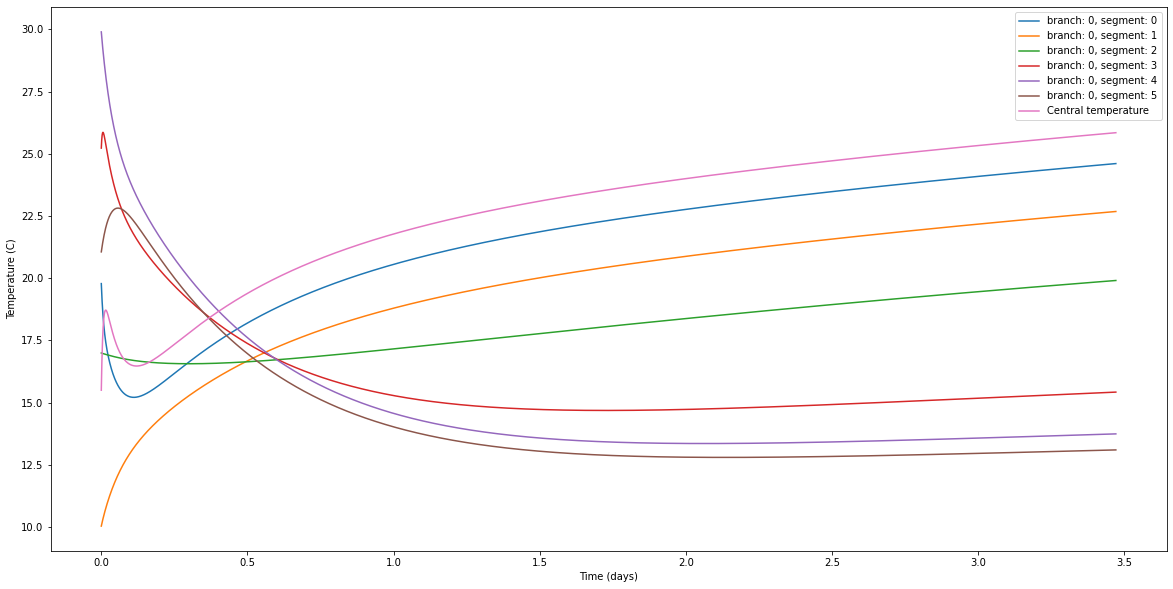

In [12]:
# More complex example, 7 segments in series
k = [6e5, 2.5e6, 1.1e7, 1.5e7, 2.1e5, 6.5e6, 6.9e6]
c = [800.0, 500.0, 300.0, 150.0, 400.0, 1000.0, 200.0]
T = [15.0, 20.0, 10.0, 17.0, 25.0, 30.0, 21.0]
T_out = 10
heatinput = 1000
# Initialise class with system parameters
sys = model_ND(k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
Ts = sys.run(iterations=5000, timestep=60)